# Further exploration

In [128]:
from pathlib2 import Path
import os

from collections import Counter

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

from tqdm.notebook import trange, tqdm

import random
import torch

In [129]:
# Set seed for all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed=42
seed_everything(seed)

In [130]:
# set seed
#np.random.seed(42)

# plot style
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

In [131]:
DATA_DIR = Path('../data')
DATA_DIR = Path('/'.join(os.getcwd().split('/')[:-1]) + '/src/data')
# Load npy-files
Xtrainval   = np.load(DATA_DIR / 'raw/npy/training.npy')
ttrainval   = np.load(DATA_DIR / 'raw/npy/training_labels.npy')
Xtest       = np.load(DATA_DIR / 'raw/npy/test.npy')

# Load matlab files
Xtrain_mat  = loadmat(DATA_DIR / 'raw/mat/training.mat', squeeze_me=True)
ttrain_mat  = loadmat(DATA_DIR / 'raw/mat/training_labels.mat', squeeze_me=True)
Xtest_mat   = loadmat(DATA_DIR / 'raw/mat/test.mat', squeeze_me=True)

# Ensure no data difference
assert np.all(Xtrain_mat['data'] == Xtrainval)
assert np.all(ttrain_mat['data'] == ttrainval)
assert np.all(Xtest_mat['data'] == Xtest)

# Clean up
del Xtrain_mat
del ttrain_mat
del Xtest_mat

In [132]:
np.random.seed(0)

# Get indexes
train_idxs  = np.random.choice(np.arange(Xtrainval.__len__()), size=int(Xtrainval.__len__() * 0.8), replace=False)
val_idxs    = np.setdiff1d(np.arange(Xtrainval.__len__()), train_idxs)

assert Xtrainval.__len__() == train_idxs.__len__() + val_idxs.__len__()

# Split training set
Xtrain_orig, Xval_orig = Xtrainval[train_idxs, :, :], Xtrainval[val_idxs, :, :]
ttrain_orig, tval_orig = ttrainval[train_idxs], ttrainval[val_idxs]

In [141]:
ddN_train   = len(Xtrain_orig)
N_val       = len(Xval_orig)
N_test      = len(Xtest)
num_classes = len(np.unique(ttrain_orig))

idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
label2idx   = {v: k for k, v in idx2label.items()}

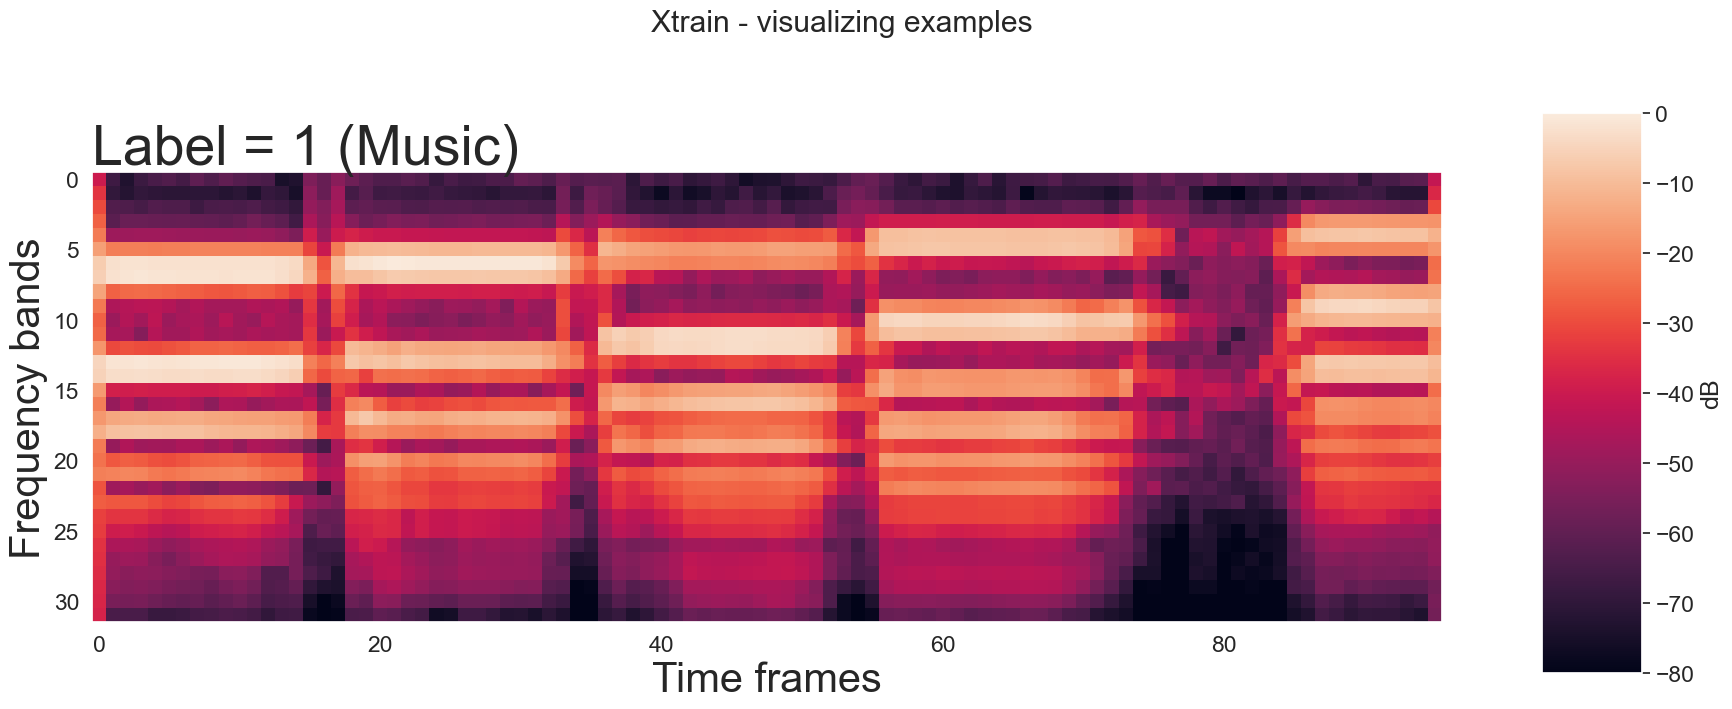

In [181]:
nrows, ncols = 5, 5

fig, ax = plt.subplots(figsize=(20, 8))

# Select class
Xtrain_class = Xtrain_orig
ttrain_class = ttrain_orig
# Select data point
idx = np.random.choice(ddN_train)
# Show spectrogram
im = ax.imshow(Xtrain_class[idx])
#ax.axis(grid='off')
ax.grid(False)
# Add label to title
ax.set_title(f"Label = {ttrain_class[idx]} ({idx2label[ttrain_class[idx]].split()[0]})", 
             loc='left', fontsize=40)
ax.set_xlabel('Time frames', fontsize=30)
ax.set_ylabel('Frequency bands', fontsize=30)
# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='dB')
fig.suptitle('Xtrain - visualizing examples')
plt.show()

In [134]:
print(f"Xtrain: {Xtrain_orig.shape}")
print(f"ttrain: {ttrain_orig.shape}")

print(f"\nXval: {Xval_orig.shape}")
print(f"tval: {tval_orig.shape}")

print(f"\nXtest: {Xtest.shape}")

print(f"\nttrain labels in --> {np.unique(ttrain_orig)}")

print(f"\nXtrain (min, max): {Xtrain_orig.min(), Xtrain_orig.max()}")
print(f"Xtest (min, max): {Xtest.min(), Xtest.max()}")

Xtrain: (42312, 32, 96)
ttrain: (42312,)

Xval: (10578, 32, 96)
tval: (10578,)

Xtest: (5347, 32, 96)

ttrain labels in --> [0 1 2 3 4]

Xtrain (min, max): (-80.0, 7.6293945e-06)
Xtest (min, max): (-80.0, 7.6293945e-06)


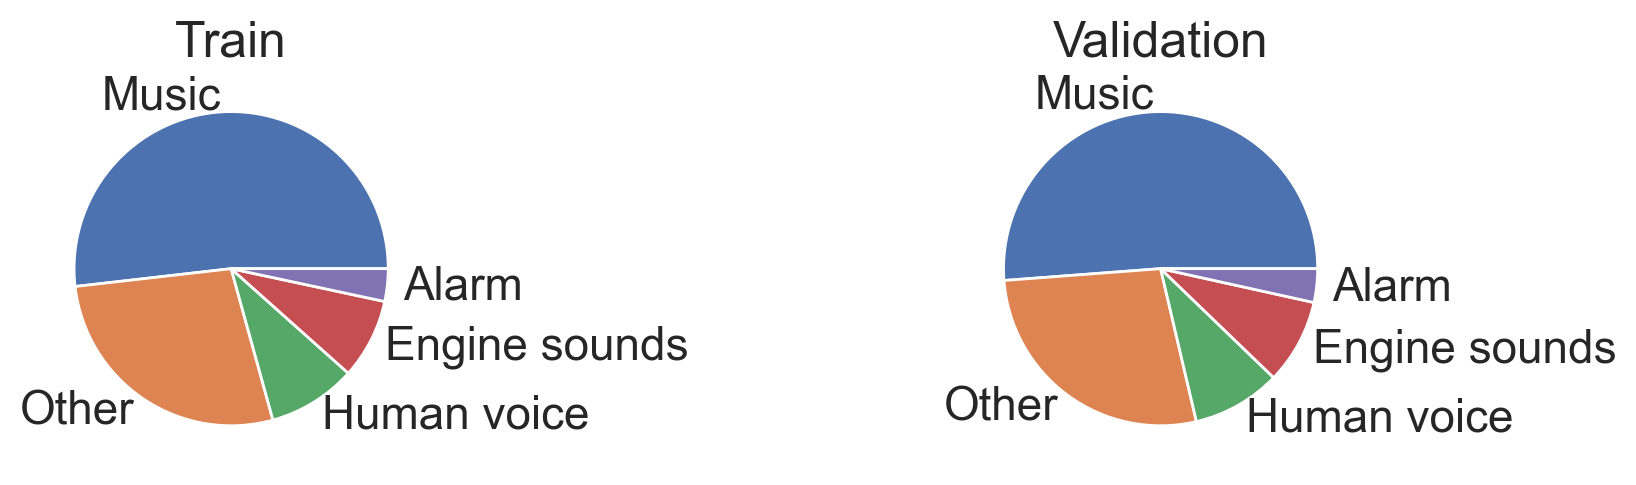

In [135]:
def visualize_label_distribution(ttrain, tval, plot = True):
    
    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
    label2idx   = {v: k for k, v in idx2label.items()}
    num_classes = len(np.unique(ttrain))
    
    N_train, N_val = len(ttrain), len(tval)
    
    label_dist = {'train': dict(sorted(Counter(ttrain).items(), key=lambda x: -x[1])), 'val': dict(sorted(Counter(tval).items(), key=lambda x: -x[1]))}

    label_counts = {dtype: {idx2label[k]: v for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}
    label_freqs = {dtype: {idx2label[k]: v / (N_train if dtype == 'train' else N_val) for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}

    if plot:
        # Plot pie chart
        fig = plt.figure(figsize=(10, 5), dpi=200)
        ax1 = plt.subplot2grid((2,2),(0,0))
        plt.pie(x=label_counts['train'].values(), labels=label_counts['train'].keys())
        plt.title('Train')

        ax1 = plt.subplot2grid((2,2), (0, 1))
        plt.pie(x=label_counts['val'].values(), labels=label_counts['val'].keys())
        plt.title('Validation')

        plt.tight_layout()
        plt.show()

    return label_counts, label_freqs

label_counts, label_freqs = visualize_label_distribution(ttrain_orig, tval_orig)


In [136]:
def downsample(Xtrain_orig, ttrain_orig):
    
    label_counts, label_freqs = visualize_label_distribution(ttrain_orig, ttrain_orig, plot = False)

    # Naive downsampling to minority class size
    target_size = min(label_counts['train'].values())

    Xtrain_downsampled, ttrain_downsampled = [], []
    num_classes = len(np.unique(ttrain_orig))
    for i in range(num_classes):
        Xtrain_class    = Xtrain_orig[ttrain_orig == i]
        ttrain_class    = ttrain_orig[ttrain_orig == i]
        N_class         = Xtrain_class.__len__()

        # Randomly draw as many points as in minority class 
        keep_idxs   = np.random.choice(np.arange(N_class), size=target_size, replace=False)

        # Downsampled class data
        Xtrain_     = Xtrain_class[keep_idxs, :]
        ttrain_     = ttrain_class[keep_idxs]

        # Append class-selected data points
        Xtrain_downsampled.append(Xtrain_)
        ttrain_downsampled.append(ttrain_)

    # Concatenate
    Xtrain_downsampled = np.vstack(Xtrain_downsampled)
    ttrain_downsampled = np.concatenate(ttrain_downsampled)
    
    return Xtrain_downsampled, ttrain_downsampled


Xtrain_downsampled, ttrain_downsampled = downsample(Xtrain_orig, ttrain_orig)

In [137]:
from typing import Optional

def standardize(X, dtype: str, mu: Optional[np.ndarray] = None, sigma: Optional[np.ndarray] = None):    
    if dtype == 'train':
        assert mu is None and sigma is None, "In training mode, the mean and standard deviation are estimated from the data."
        # Compute moments
        mu, sigma = np.mean(X, axis=0).reshape(1, X.shape[1], X.shape[2]), np.std(X, axis=0).reshape(1, X.shape[1], X.shape[2]), 
    else:
        assert mu is not None and sigma is not None, "Specify mean and standard deviation when running in evaluation mode."
    
    # Standardize
    X_ = (X - mu) / sigma
    return X_, mu, sigma

In [11]:
# Select which dataset version we want to run with
Xtrain                  = Xtrain_downsampled
ttrain                  = ttrain_downsampled
Xval                    = Xval_orig

# Standardize
Xtrain, mu_, sigma_     = standardize(Xtrain, dtype='train')
Xval, _, _              = standardize(Xval, dtype='evaluation', mu=mu_, sigma=sigma_)

N_train = Xtrain.__len__()

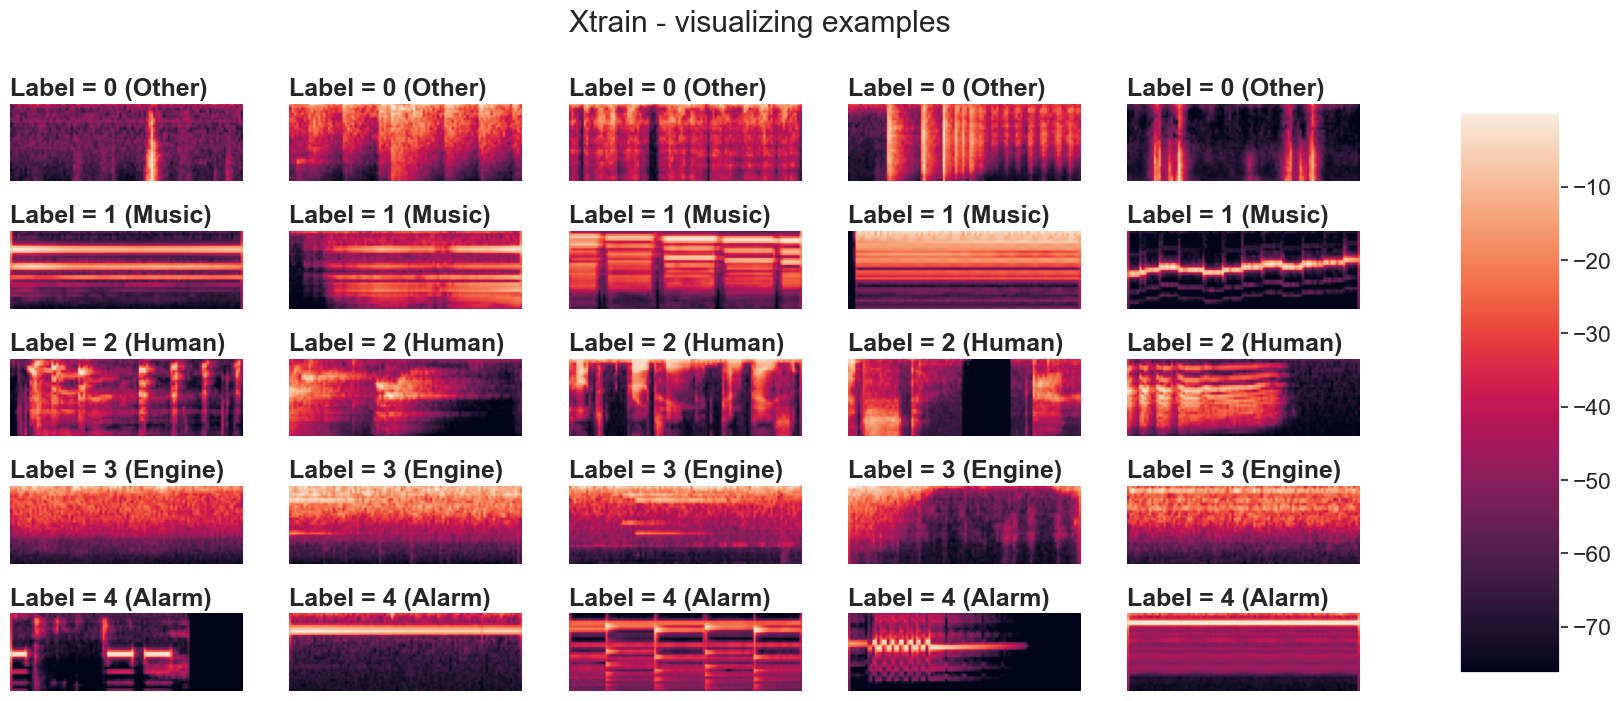

In [ ]:
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
for i in range(nrows):
    for j in range(ncols):

        # Select class
        Xtrain_class = Xtrain_orig[ttrain_orig == i]
        ttrain_class = ttrain_orig[ttrain_orig == i]
        # Select data point
        idx = np.random.choice(len(Xtrain_class))
        # Show spectrogram
        im = axs[i, j].imshow(Xtrain_class[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = {ttrain_class[idx]} ({idx2label[ttrain_class[idx]].split()[0]})", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xtrain - visualizing examples')
plt.show()

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

# Transform data to PCA space
Xtrain_pca  = pca.fit_transform(Xtrain.reshape(N_train, -1), ttrain)
Xval_pca    = pca.transform(Xval.reshape(N_val, -1))

N_pca_comp = (~(pca.explained_variance_ratio_.cumsum() > 0.9)).sum()
print(f"Number of components at threshold of 90%: {N_pca_comp}")

Number of components at threshold of 90%: 48


In [13]:
# Specify new PCA features for use
Xtrain_pca  = Xtrain_pca[:, :N_pca_comp]
Xval_pca    = Xval_pca[:, :N_pca_comp]

In [14]:
# Select which dataset version we want to run with

def get_dataset_version(version = 'original'):
    
    if version.lower() == 'original':
        Xtrain    = Xtrain_orig
        Xval      = Xval_orig
        ttrain    = ttrain_orig
        
    elif version.lower() == 'downsampled':
        Xtrain    = Xtrain_downsampled
        Xval      = Xval_orig
        ttrain    = ttrain_downsampled
        
    elif version.lower() == 'pca':
        if len(Xtrain_pca) == len(ttrain_orig):
            ttrain    = ttrain_orig
        else:
            ttrain    = ttrain_downsampled
            
        Xtrain    = Xtrain_pca.reshape(len(ttrain), -1, 1)
        Xval      = Xval_pca.reshape(len(tval_orig), -1, 1)

    return Xtrain, Xval, ttrain

In [15]:
Xtrain, Xval, ttrain = get_dataset_version('downsampled')

# Standardize
Xtrain, mu_, sigma_     = standardize(Xtrain, dtype='train')
Xval, _, _              = standardize(Xval, dtype='evaluation', mu=mu_, sigma=sigma_)

N_train = Xtrain.__len__()

In [16]:
#design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x))
design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
one_hot_encode  = lambda t: np.eye(num_classes)[t] 

# Create design matrices (for full data)
Phi_train       = design_matrix(Xtrain.reshape(N_train, -1))
Phi_val         = design_matrix(Xval.reshape(N_val, -1))
Phi_test        = design_matrix(Xtest.reshape(N_test, -1))

# Number of parameters
n_params        = Phi_train.shape[1]

# One-of-K encode targets
ttrain_enc      = one_hot_encode(ttrain)
tval_enc        = one_hot_encode(tval_orig)

In [17]:
# Get ridge solution
lambd_ = 10.
theta_hat_Ridge = np.linalg.solve(Phi_train.T @ Phi_train + lambd_ * np.eye(n_params), Phi_train.T @ ttrain_enc)

print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Number of parameters: {theta_hat_Ridge.shape}")
print(f"Magnitude {np.linalg.norm(theta_hat_Ridge, ord=2)}")


--- RIDGE ESTIMATE OBTAINED ---
Number of parameters: (6145, 5)
Magnitude 3.1455804877137012


In [18]:
# define softmax
softmax = lambda y: np.exp(y) / np.exp(y).sum(axis=1)[:, np.newaxis]

def predict(Phi: np.ndarray, theta: np.ndarray) -> (np.ndarray, np.ndarray):
    

    # get latent function value
    y = Phi @ theta

    # get soft probabilty scores
    prob = softmax(y)

    # get topk predictions
    pred = prob.argmax(axis=1)

    return pred, prob

# Get Ridge predictions 
ttrain_hat_Ridge, ttrain_prob_Ridge = predict(Phi_train, theta_hat_Ridge)
tval_hat_Ridge, tval_prob_Ridge     = predict(Phi_val, theta_hat_Ridge)

In [19]:
print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_Ridge == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_Ridge == tval_orig).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_Ridge):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, tval_hat_Ridge):.4f}")


--- RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.9945
Accuracy validation: 0.3780
Balanced accuracy train: 0.9945
Balanced accuracy validation: 0.3384


In [20]:
    
def visualize_confusion_matrix(fig, ax, cm_, reg_type, dtype):
    # Plot confusion matrix as heatmap
    sns.heatmap(cm_, annot=True, cmap='Blues', ax=ax)

    # Set ticks
    ticks = list(zip(*[(i + 0.5, name_) for i, name_ in idx2label.items()]))
    ax.set_xticks(ticks[0], ticks[1], rotation=25)
    ax.set_yticks(ticks[0], ticks[1], rotation=0)

    # Set labels and title
    ax.set_ylabel('Actual', weight='bold')
    ax.set_xlabel('Predicted', weight='bold')
    ax.set_title(f"Confusion matrix: {dtype}".upper())
    fig.suptitle(f'{reg_type}'.upper(), weight='bold')
    return fig, ax

## t-SNE

In [21]:
from sklearn.manifold import TSNE


In [22]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

Xtrain, Xval, ttrain = get_dataset_version('downsampled')

# Standardize
Xtrain, mu_, sigma_     = standardize(Xtrain, dtype='train')
Xval, _, _              = standardize(Xval, dtype='evaluation', mu=mu_, sigma=sigma_)


tsne_results = tsne.fit_transform(Xtrain.reshape(N_train, -1))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7095 samples in 0.006s...
[t-SNE] Computed neighbors for 7095 samples in 5.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7095
[t-SNE] Computed conditional probabilities for sample 2000 / 7095
[t-SNE] Computed conditional probabilities for sample 3000 / 7095
[t-SNE] Computed conditional probabilities for sample 4000 / 7095
[t-SNE] Computed conditional probabilities for sample 5000 / 7095
[t-SNE] Computed conditional probabilities for sample 6000 / 7095
[t-SNE] Computed conditional probabilities for sample 7000 / 7095
[t-SNE] Computed conditional probabilities for sample 7095 / 7095
[t-SNE] Mean sigma: 9.438548
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.053146
[t-SNE] KL divergence after 300 iterations: 2.840289


/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_17202/3951282281.py:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne component one', ylabel='tsne component two'>

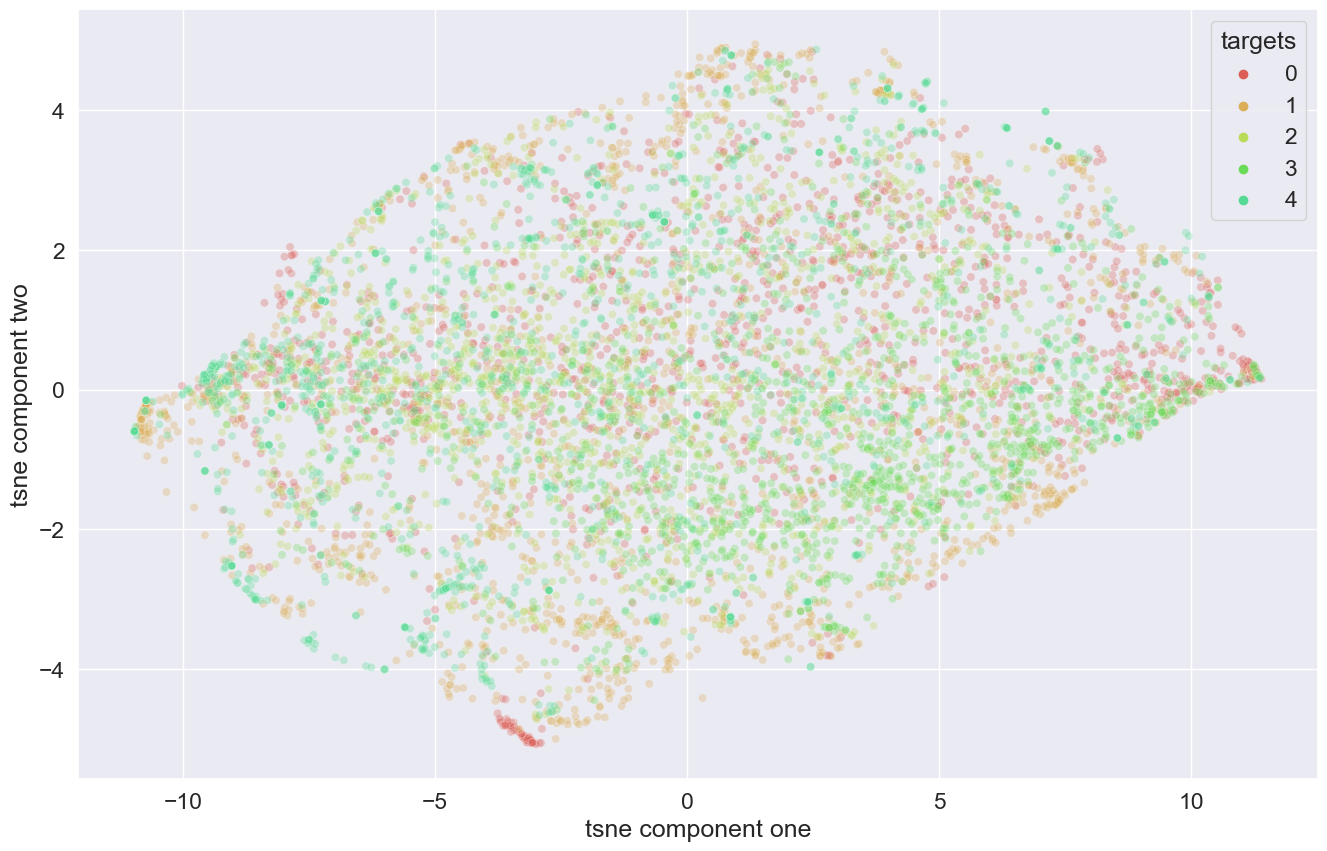

In [23]:
tsne = {}
tsne['targets'] = ttrain
tsne['tsne component one'] = tsne_results[:,0]
tsne['tsne component two'] = tsne_results[:,1]


plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne component one", y="tsne component two",
    hue="targets",
    palette=sns.color_palette("hls", 10),
    data=tsne,
    legend="full",
    alpha=0.3
)

## kernel PCA (non-linear)

In [24]:
from sklearn.decomposition import KernelPCA

In [68]:
ncomp=3
kernelpca = KernelPCA(n_components=ncomp, kernel='rbf')
X_transformed = kernelpca.fit_transform(Xtrain.reshape(N_train, -1))
Xval_transformed = kernelpca.transform(Xval.reshape(N_val, -1))

In [69]:
# inspired from: https://plotly.com/python/pca-visualization/

tval_name = [idx2label[t] for t in tval_orig]

labels = {
    str(i): f"Component {i+1}"
    for i in range(ncomp)
}

fig = px.scatter_matrix(
    Xval_transformed,
    labels=labels,
    dimensions=range(3),
    color=np.array(tval_name)
)
fig.update_traces(diagonal_visible=False)
fig.show(renderer='iframe')

In [70]:
fig = px.scatter_3d(
    Xval_transformed, x=0, y=1, z=2, 
    color=np.array(tval_name),
    title=f'Kernel PCA',
    labels={'0': 'Component 1', '1': 'Component 2', '2': 'Component 3'}
)
fig.update_traces(marker_size = 4)

fig.show(renderer='iframe')

# Attempts:
### - at creating a good classifier, disregarding size

## Baselines

#### Comparing PCA and LDA using a RF model:

In [31]:
from sklearn.ensemble import RandomForestClassifier


#### PCA:


In [141]:
depth = []
acc = []
for i in range(1,31):
    classifier = RandomForestClassifier(max_depth=i, random_state=seed)
    classifier.fit(Xtrain_pca, ttrain)
    y_pred = classifier.predict(Xval_pca)
    acc.append((y_pred == tval_orig).mean())
    depth.append(i)

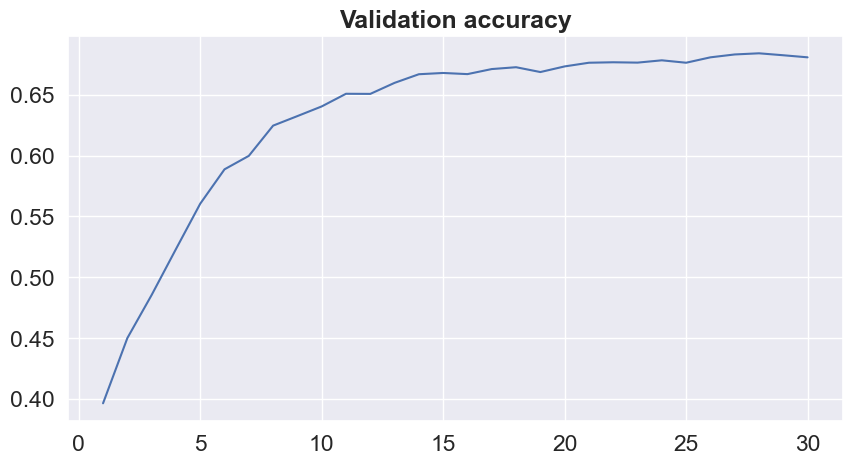


Best validation accuracy: 0.684 with depth: 28


In [149]:
plt.figure(figsize=(10,5))
plt.plot(depth, acc, color='C0', label='Validation accuracy')
plt.title('Validation accuracy', weight='bold')
plt.show()

best_depth = depth[np.argmax(acc)]

print(f'\nBest validation accuracy: {round(max(acc),3)} with depth: {best_depth}')

In [150]:
classifier = RandomForestClassifier(max_depth=best_depth, random_state=seed)
classifier.fit(Xtrain_pca, ttrain)
y_pred = classifier.predict(Xval_pca)

In [151]:
print("\n--- PCA + RF ESTIMATE OBTAINED ---")
print(f"Accuracy validation: {(y_pred == tval_orig).mean():.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, y_pred):.4f}")


--- PCA+RF ESTIMATE OBTAINED ---
Accuracy validation: 0.6804
Balanced accuracy validation: 0.6669


#### Kernel PCA:

In [83]:
ncomp=48
kernelpca = KernelPCA(n_components=ncomp, kernel='rbf')
X_transformed = kernelpca.fit_transform(Xtrain.reshape(N_train, -1))
Xval_transformed = kernelpca.transform(Xval.reshape(N_val, -1))

In [84]:
classifier = RandomForestClassifier(max_depth=28, random_state=seed)
classifier.fit(X_transformed, ttrain)
y_pred = classifier.predict(Xval_transformed)

In [85]:
print("\n--- Kernel PCA + RF ESTIMATE OBTAINED ---")
print(f"Accuracy validation: {(y_pred == tval_orig).mean():.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, y_pred):.4f}")


--- Kernel PCA + RF ESTIMATE OBTAINED ---
Accuracy validation: 0.6561
Balanced accuracy validation: 0.6540


#### LDA:

In [120]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [152]:
lda = LDA() # todo: n_components
Xtrain_lda = lda.fit_transform(Xtrain.reshape(N_train, -1), ttrain)
Xval_lda = lda.transform(Xval.reshape(N_val, -1))

In [154]:
Xtrain_lda.shape

(7095, 4)

In [156]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=best_depth, random_state=0)

classifier.fit(Xtrain_lda, ttrain)
y_pred = classifier.predict(Xval_lda)

In [157]:
print("\n--- LDA + RF ESTIMATE OBTAINED ---")
print(f"Accuracy validation: {(y_pred == tval_orig).mean():.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, y_pred):.4f}")


--- LDA+RF ESTIMATE OBTAINED ---
Accuracy validation: 0.3707
Balanced accuracy validation: 0.3409


PCA clearly outperforms??
- but uses a lot more features

In [164]:
# from: https://stackoverflow.com/questions/51139875/sklearn-randomforestregressor-number-of-trainable-parameters
# Each binary tree is described by left & righ children, feature, threshold, and value for each node.
n_params = sum(tree.tree_.node_count for tree in classifier.estimators_) * 5
print(f"Total number of parameters: {n_params:d}")



Total number of parameters: 841220


## Using CNN

Inspired from: https://www.section.io/engineering-education/machine-learning-for-audio-classification/

### CNN: Using PCA data (i.e. 1D)

In [116]:
Xtrain, Xval, ttrain = get_dataset_version('downsampled')

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

#### building model

In [89]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(Xtrain_pca.shape[1], )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Metal device set to: Apple M1


In [90]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

#### training model

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 


In [73]:

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
# One-of-K encode targets
history = model.fit(Xtrain_pca, ttrain_enc, batch_size=num_batch_size, epochs=num_epochs, validation_data=(Xval_pca, tval_enc), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
222/222 [==============================] - ETA: 0s - loss: 2.5431 - accuracy: 0.2864
Epoch 1: val_loss improved from inf to 1.54588, saving model to saved_models/audio_classification.hdf5
222/222 [==============================] - 9s 28ms/step - loss: 2.5431 - accuracy: 0.2864 - val_loss: 1.5459 - val_accuracy: 0.2993
Epoch 2/200
221/222 [============================>.] - ETA: 0s - loss: 1.5858 - accuracy: 0.3481
Epoch 2: val_loss did not improve from 1.54588
222/222 [==============================] - 6s 26ms/step - loss: 1.5851 - accuracy: 0.3484 - val_loss: 1.5486 - val_accuracy: 0.2663
Epoch 3/200
221/222 [============================>.] - ETA: 0s - loss: 1.4528 - accuracy: 0.3863
Epoch 3: val_loss improved from 1.54588 to 1.52650, saving model to saved_models/audio_classification.hdf5
222/222 [==============================] - 6s 29ms/step - loss: 1.4527 - accuracy: 0.3862 - val_loss: 1.5265 - val_accuracy: 0.2997
Epoch 4/200
220/222 [============================>.] - E

Epoch 28/200
221/222 [============================>.] - ETA: 0s - loss: 0.9972 - accuracy: 0.6171
Epoch 28: val_loss did not improve from 1.10090
222/222 [==============================] - 6s 26ms/step - loss: 0.9971 - accuracy: 0.6172 - val_loss: 1.1820 - val_accuracy: 0.5486
Epoch 29/200
221/222 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.6188
Epoch 29: val_loss did not improve from 1.10090
222/222 [==============================] - 6s 26ms/step - loss: 0.9865 - accuracy: 0.6193 - val_loss: 1.1061 - val_accuracy: 0.5827
Epoch 30/200
221/222 [============================>.] - ETA: 0s - loss: 0.9855 - accuracy: 0.6184
Epoch 30: val_loss did not improve from 1.10090
222/222 [==============================] - 6s 28ms/step - loss: 0.9850 - accuracy: 0.6187 - val_loss: 1.1067 - val_accuracy: 0.5813
Epoch 31/200
220/222 [============================>.] - ETA: 0s - loss: 0.9700 - accuracy: 0.6327
Epoch 31: val_loss did not improve from 1.10090
222/222 [===========

222/222 [==============================] - 6s 26ms/step - loss: 0.8426 - accuracy: 0.6853 - val_loss: 1.1033 - val_accuracy: 0.5903
Epoch 57/200
222/222 [==============================] - ETA: 0s - loss: 0.8332 - accuracy: 0.6872
Epoch 57: val_loss did not improve from 1.01853
222/222 [==============================] - 6s 26ms/step - loss: 0.8332 - accuracy: 0.6872 - val_loss: 1.0523 - val_accuracy: 0.6158
Epoch 58/200
221/222 [============================>.] - ETA: 0s - loss: 0.8379 - accuracy: 0.6803
Epoch 58: val_loss did not improve from 1.01853
222/222 [==============================] - 6s 26ms/step - loss: 0.8377 - accuracy: 0.6803 - val_loss: 1.0436 - val_accuracy: 0.6182
Epoch 59/200
220/222 [============================>.] - ETA: 0s - loss: 0.8312 - accuracy: 0.6866
Epoch 59: val_loss improved from 1.01853 to 1.00443, saving model to saved_models/audio_classification.hdf5
222/222 [==============================] - 6s 26ms/step - loss: 0.8314 - accuracy: 0.6867 - val_loss: 1.00

Epoch 114/200
222/222 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.7340
Epoch 114: val_loss improved from 0.95514 to 0.94608, saving model to saved_models/audio_classification.hdf5
222/222 [==============================] - 6s 26ms/step - loss: 0.7029 - accuracy: 0.7340 - val_loss: 0.9461 - val_accuracy: 0.6676
Epoch 115/200
221/222 [============================>.] - ETA: 0s - loss: 0.7075 - accuracy: 0.7350
Epoch 115: val_loss did not improve from 0.94608
222/222 [==============================] - 6s 26ms/step - loss: 0.7077 - accuracy: 0.7352 - val_loss: 1.0034 - val_accuracy: 0.6432
Epoch 116/200
220/222 [============================>.] - ETA: 0s - loss: 0.7113 - accuracy: 0.7385
Epoch 116: val_loss did not improve from 0.94608
222/222 [==============================] - 6s 26ms/step - loss: 0.7129 - accuracy: 0.7378 - val_loss: 1.0408 - val_accuracy: 0.6318
Epoch 117/200
221/222 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.7373
E

219/222 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.7454
Epoch 143: val_loss did not improve from 0.94608
222/222 [==============================] - 6s 26ms/step - loss: 0.6746 - accuracy: 0.7445 - val_loss: 1.0068 - val_accuracy: 0.6486
Epoch 144/200
220/222 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.7425
Epoch 144: val_loss did not improve from 0.94608
222/222 [==============================] - 6s 26ms/step - loss: 0.6900 - accuracy: 0.7435 - val_loss: 1.0075 - val_accuracy: 0.6445
Epoch 145/200
220/222 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.7507
Epoch 145: val_loss did not improve from 0.94608
222/222 [==============================] - 6s 26ms/step - loss: 0.6691 - accuracy: 0.7508 - val_loss: 1.0065 - val_accuracy: 0.6478
Epoch 146/200
222/222 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.7412
Epoch 146: val_loss did not improve from 0.94608
222/222 [=================

val_accuracy: 0.6690

#### evaluating model

In [ ]:
#test_accuracy=model.evaluate(X_test,y_test,verbose=0)
#print(test_accuracy[1])

In [77]:
val_acc = model.evaluate(Xval_pca, tval_enc, verbose=0)[1]
print(f'Validation accuracy: {val_acc}')

Validation accuracy: 0.6690300703048706


In [87]:
preds = model.predict(Xval_pca, verbose=0)
preds_ = preds.argmax(axis=1)

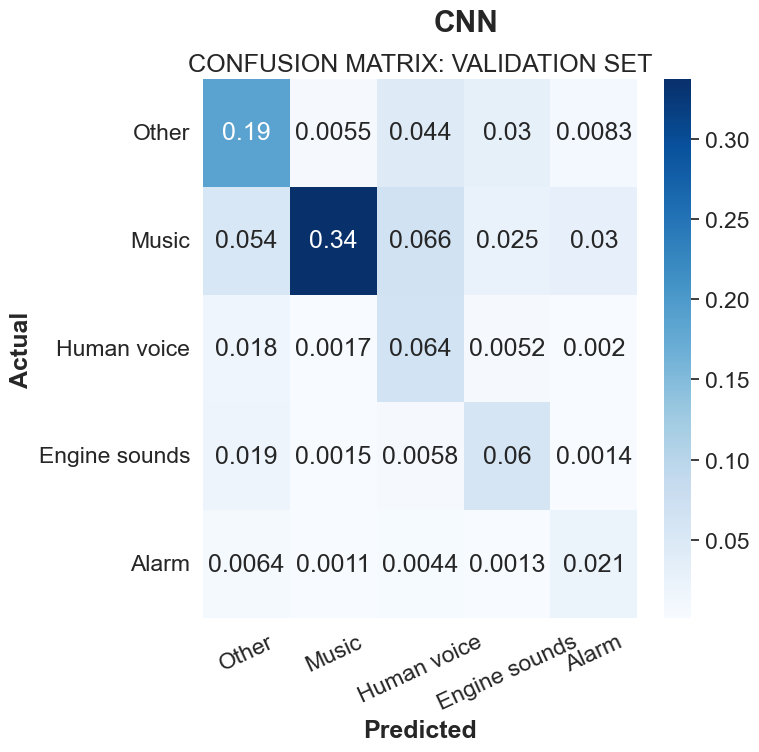

In [98]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

# plotting the new confusion matrix
cm_val_Ridge   = confusion_matrix(tval_orig, preds_, normalize='all')
fig, ax = visualize_confusion_matrix(fig, ax, cm_val_Ridge, 'CNN', 'validation set')

plt.show()

In [101]:
print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy validation: {(tval_hat_Ridge == tval_orig).mean():.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, tval_hat_Ridge):.4f}")

print("\n--- CNN ESTIMATE OBTAINED ---")
print(f"Accuracy validation: {(preds_ == tval_orig).mean():.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval_orig, preds_):.4f}")


--- RIDGE ESTIMATE OBTAINED ---
Accuracy validation: 0.3780
Balanced accuracy validation: 0.3384

--- CNN ESTIMATE OBTAINED ---
Accuracy validation: 0.6690
Balanced accuracy validation: 0.6676


In [86]:
Xtrain.shape

(7095, 32, 96)

### CNN: Using the spectrograms (i.e. 2D)

In [106]:
import tensorflow as tf

In [100]:
Xtrain.shape[1:]

(32, 96)

In [110]:
H, W = Xtrain.shape[1:]
C = 1

In [125]:
# inspired from: https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(H, W, C)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [126]:
# Compile model
#model.compile(
#    loss='categorical_crossentropy',
#    optimizer=tf.keras.optimizers.RMSprop(),
#    metrics=['accuracy'],
#)
# TODO: tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# then each data belongs to 1 class

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')


In [127]:

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
# One-of-K encode targets
history = model.fit(Xtrain, ttrain_enc, batch_size=num_batch_size, epochs=num_epochs, validation_data=(Xval, tval_enc), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
222/222 [==============================] - ETA: 0s - loss: 1.3978 - accuracy: 0.5047
Epoch 1: val_loss improved from inf to 1.35438, saving model to saved_models/audio_classification2.hdf5
222/222 [==============================] - 26s 104ms/step - loss: 1.3978 - accuracy: 0.5047 - val_loss: 1.3544 - val_accuracy: 0.4918
Epoch 2/200
222/222 [==============================] - ETA: 0s - loss: 0.9890 - accuracy: 0.6371
Epoch 2: val_loss did not improve from 1.35438
222/222 [==============================] - 18s 83ms/step - loss: 0.9890 - accuracy: 0.6371 - val_loss: 1.4265 - val_accuracy: 0.5073
Epoch 3/200
222/222 [==============================] - ETA: 0s - loss: 0.8476 - accuracy: 0.6898
Epoch 3: val_loss improved from 1.35438 to 1.06755, saving model to saved_models/audio_classification2.hdf5
222/222 [==============================] - 18s 80ms/step - loss: 0.8476 - accuracy: 0.6898 - val_loss: 1.0675 - val_accuracy: 0.5977
Epoch 4/200
222/222 [=============================

Epoch 30/200
222/222 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9753
Epoch 30: val_loss did not improve from 0.70250
222/222 [==============================] - 17s 76ms/step - loss: 0.0684 - accuracy: 0.9753 - val_loss: 1.1505 - val_accuracy: 0.7318
Epoch 31/200
222/222 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9684
Epoch 31: val_loss did not improve from 0.70250
222/222 [==============================] - 18s 79ms/step - loss: 0.0859 - accuracy: 0.9684 - val_loss: 1.4709 - val_accuracy: 0.7035
Epoch 32/200
222/222 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9752
Epoch 32: val_loss did not improve from 0.70250
222/222 [==============================] - 21s 94ms/step - loss: 0.0661 - accuracy: 0.9752 - val_loss: 1.4017 - val_accuracy: 0.7204
Epoch 33/200
222/222 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9842
Epoch 33: val_loss did not improve from 0.70250
222/222 [========

KeyboardInterrupt: 

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

## Using transformers

Note: need cuda
- solution, cuda or e.g. colab

#### Initializing

In [50]:
# the model
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_classes, label2id=label2idx, id2label=idx2label
)

/Users/arond.jacobsen/miniforge3/envs/myenv/lib/python3.9/site-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_hid.bias', 'project_q.bias', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'projector.bias', 'classifier.

In [ ]:
# evaluation
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

#### Training

In [51]:
training_args = TrainingArguments(
    output_dir="my_awesome_mind_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)


NameError: name 'PartialState' is not defined

In [52]:
# todo:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

NameError: name 'training_args' is not defined

In [ ]:

trainer.train()